# **Reconstruccion de Color**

## Haciendo uso de Programacion Genetica (PG)

-----

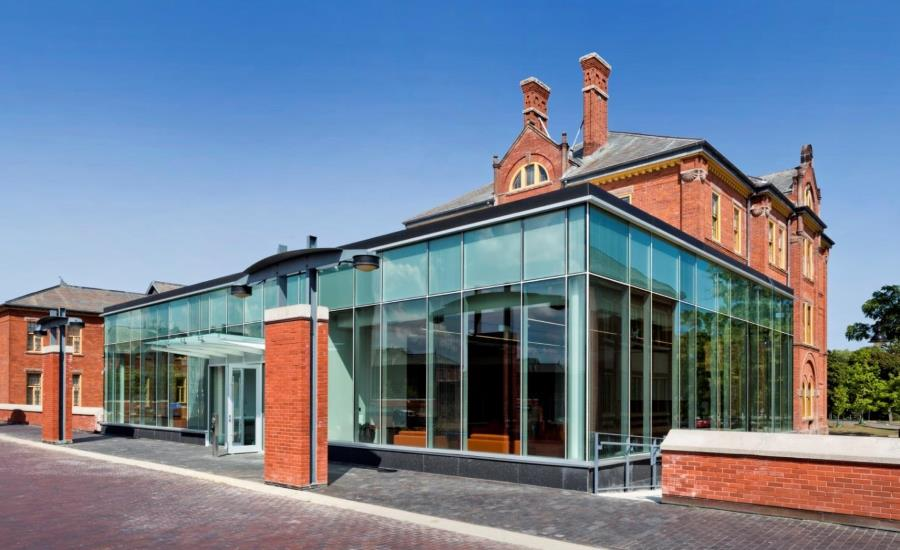

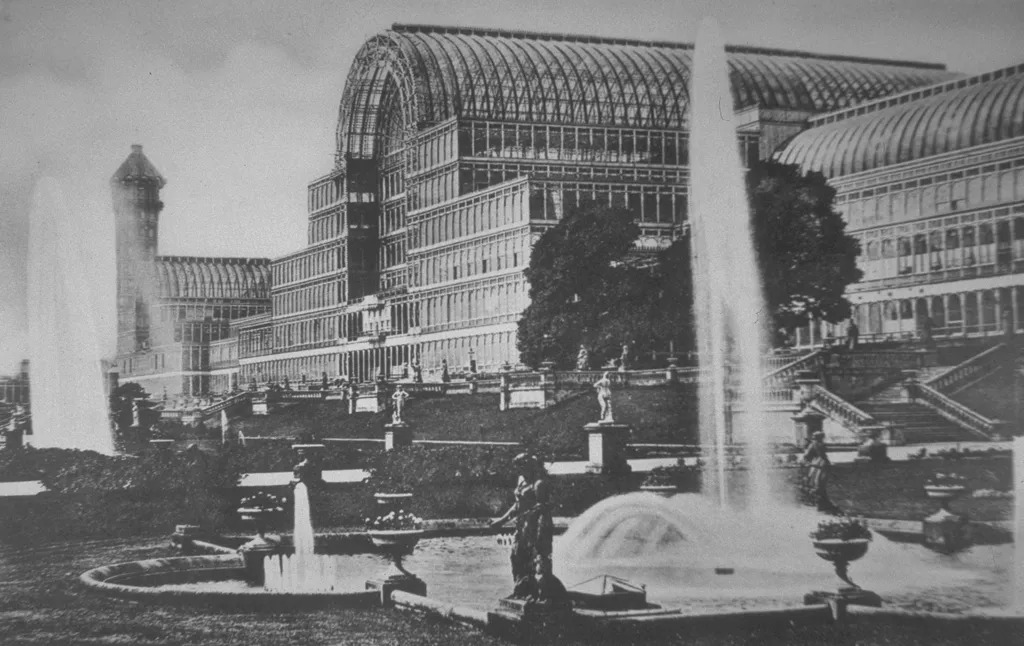

In [2]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.0 MB/s eta 0:00:00


<string>:1: RuntimeWarning: overflow encountered in ubyte_scalars


   	      	                                 fitness                                  	                      size                     
   	      	--------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max        	min       	nevals	std       	avg	gen	max	min	nevals	std    
0  	20    	7.40544e+09	0  	3.36099e+10	6.0747e+08	20    	9.3607e+09	4.5	0  	7  	3  	20    	1.88414
1  	8     	3.73735e+09	1  	1.13904e+10	6.0747e+08	8     	4.01698e+09	4.7	1  	9  	3  	8     	1.92614
2  	19    	2.34552e+09	2  	8.19457e+09	6.0747e+08	19    	3.02376e+09	4.4	2  	7  	3  	19    	1.56205
3  	16    	9.17325e+12	3  	1.83408e+14	6.17563e+08	16    	3.99723e+13	4  	3  	11 	1  	16    	1.94936
4  	7     	8.61643e+08	4  	5.4216e+09 	6.17563e+08	7     	1.04614e+09	4  	4  	7  	3  	7     	1.18322
5  	16    	4.45428e+09	5  	3.36099e+10	6.17563e+08	16    	7.7033e+09 	4  	5  	9  	3  	16    	1.48324
6  	12    	2.45038e+09	6  	1.12

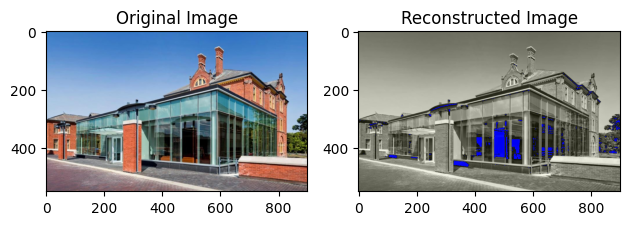

In [18]:
import operator
import random
import numpy as np
import cv2
from deap import base, creator, gp, tools, algorithms
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load color image and convert it to grayscale
image = cv2.imread('/content/B41.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Define new primitive set
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(max, 2)
pset.addPrimitive(min, 2)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
pset.renameArguments(ARG0='x')

# Define the individual and fitness base
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Define the evaluation function
def evaluate(individual, color_channel):
    func = toolbox.compile(expr=individual)
    total_error = 0
    for x in range(gray_image.shape[0]):
        for y in range(gray_image.shape[1]):
            predicted = func(gray_image[x, y])
            actual = image[x, y][color_channel]
            error = (int(predicted) - int(actual)) ** 2
            total_error += error
    return total_error,

toolbox.register("evaluate", evaluate)

toolbox.register("evaluate_r", evaluate, color_channel=2)
toolbox.register("evaluate_g", evaluate, color_channel=1)
toolbox.register("evaluate_b", evaluate, color_channel=0)

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

# Statistics to be collected
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Hall of Fame to store the best individuals
hof_r = tools.HallOfFame(1)
hof_g = tools.HallOfFame(1)
hof_b = tools.HallOfFame(1)

# Separate populations for each color channel
population_r = toolbox.population(n=20)
population_g = toolbox.population(n=20)
population_b = toolbox.population(n=20)

# Evolve the populations separately
toolbox.unregister("evaluate")
toolbox.register("evaluate", toolbox.evaluate_r)
algorithms.eaSimple(population_r, toolbox, 0.5, 0.1, 20, stats=mstats, halloffame=hof_r, verbose=True)

toolbox.unregister("evaluate")
toolbox.register("evaluate", toolbox.evaluate_g)
algorithms.eaSimple(population_g, toolbox, 0.5, 0.1, 20, stats=mstats, halloffame=hof_g, verbose=True)

toolbox.unregister("evaluate")
toolbox.register("evaluate", toolbox.evaluate_b)
algorithms.eaSimple(population_b, toolbox, 0.5, 0.1, 20, stats=mstats, halloffame=hof_b, verbose=True)

# Compile functions from the best individuals
func_r = toolbox.compile(expr=hof_r[0])
func_g = toolbox.compile(expr=hof_g[0])
func_b = toolbox.compile(expr=hof_b[0])

# Reconstruct the color image
reconstructed_image = np.zeros_like(image)
for x in range(gray_image.shape[0]):
    for y in range(gray_image.shape[1]):
        r = func_r(gray_image[x, y])
        g = func_g(gray_image[x, y])
        b = func_b(gray_image[x, y])
        reconstructed_image[x, y] = [r, g, b]

# Save the reconstructed image
cv2.imwrite('reconstructed_image.jpg', reconstructed_image)

# Display the original and reconstructed images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))
plt.title('Reconstructed Image')

plt.tight_layout()
plt.show()
